# Keras(TensorFlow)에서 제공하는 패션 MNIST 데이터를 가지고 인공신경망 학습하기

In [31]:
# 실행마다 동일한 결과를 얻기 위해 케라스 랜덤 시드를 사용하도록 설정
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [32]:
# 패션 MNIST를 가져오기 위해 Keras를 import
from tensorflow import keras

# 패션 훈련데이터와 테스트(검증) 데이터를 나눠주는 함수 사용
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

In [33]:
print(train_input.shape, train_target.shape)  # 60,000개의 이미지를 가지며 각 이미지는 28 * 28 크기를 가짐
print(test_input.shape, test_target.shape)    # 10,000개의 이미지를 가지며 각 이미지는 28 * 28 크기를 가짐

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


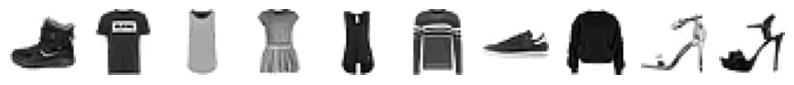

In [34]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 10, figsize=(10, 10))
# 앞에서부터 10개의 28 * 28의 이미지로 grayscale로 출력
for i in range(10):
    axs[i].imshow(train_input[i].reshape(28, 28), cmap='gray_r')
    axs[i].axis('off')

plt.show()

In [35]:
# train_target에 레이블링된 숫자 확인하기
print([train_target[i] for i in range(10)])

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


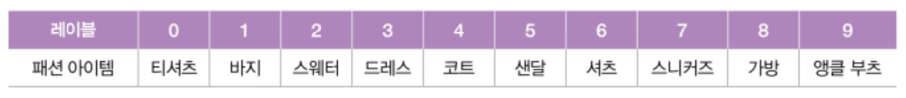

In [36]:
# 훈련 데이터 세트의 레이블(0~9)당 샘플 개수 확인하기
import numpy as np

print(np.unique(train_target, return_counts=True)) # 각 레이블당 6000개의 28*28크기의 이미지를 가지고 있음

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


# 로지스틱 회귀 알고리즘으로 패션 MNIST 아이템 분류하기

In [37]:
# 필요한 사전지식
# 이미지 같은 RGB -> Red(0~255), Green(0~ 255), Blue(0~255)
# 로지스틱 회귀 알고리즘 사용하기 위해 2차원 배열로 변형(3차원 -> 2차원)

train_scaled = train_input / 255.0
train_scaled = train_scaled.reshape(-1, 28*28)

print(train_scaled.shape)

(60000, 784)


In [13]:
# 로지스틱 회귀 알고리즘인 SGDClassifier 사용하기
from sklearn.model_selection import cross_validate
from  sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss='log_loss', max_iter=10, random_state=42)
scores = cross_validate(sgd, train_scaled, train_target, n_jobs=-1)

print(np.mean(scores['test_score']))


0.8312999999999999


# 사이킷런이 아닌 인공 신경망(딥러닝)으로 keras프레임워크로 모델 만들기

In [38]:
# train_test_split 함수로 훈련데이터와 테스트데이터로 나누기
from sklearn.model_selection import train_test_split

# train_scaled 세트에서 20%로만 검증 세트로 해서 훈련데이터(80%)와 테스트(검증)데이터(20%)로 split -> 6만개의 80%: 4.8만개  6만개의 20%: 1.2만개
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [39]:
print(train_scaled.shape, train_target.shape)
print(val_scaled.shape, val_target.shape)

(48000, 784) (48000,)
(12000, 784) (12000,)


In [40]:
# keras 라이브러리로 인공신경망 실제 모델 생성
# keras 레이어로 정의
dense = keras.layers.Dense(10, activation='softmax', input_shape=(784,)) # (10은 뉴런의 개수(분류개수), 뉴런의 출력에 적용할 활성화함수, 입력크기)

# Sequential모델에 레이어를 추가하여 딥러닝모델 생성
model = keras.Sequential([dense])

# 모델 구조 출력
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

# 만들어진 인공신경망 모델로 패션 아이템 분류하기


In [41]:
# 만들어진 케라스 인공신경망 모델에서는 compile이라는 메소드를 실행해야하는 설정을 꼭 해야함
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])   # categorical_crossentropy 다중 분류일 때 사용, binary_crossentropy 이진 분류일 때 사용

model.fit(train_scaled, train_target, epochs=5)  # epochs는 에폭값으로 한번 iteration값

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7370 - loss: 0.7853
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8346 - loss: 0.4845
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8452 - loss: 0.4564
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8504 - loss: 0.4425
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8537 - loss: 0.4337


In [26]:
print(train_target[:10])

[9 4 9 0 4 9 3 6 4 7]


In [42]:
# 모델에서 실제 측정할 데이터를 넣어 평가하기
model.evaluate(val_scaled, val_target)  # 사이킷런 score과 비슷

# 실제 모델예측
predictions = model.predict(val_scaled[:5])

# 예측 출력
print(predictions)


375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8462 - loss: 0.4364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
[[2.42111087e-09 1.09111005e-08 5.80457436e-06 7.50701759e-07
  4.09736003e-07 1.00750132e-02 4.79155369e-06 7.49329558e-08
  9.89913106e-01 7.02969905e-10]
 [1.15815283e-07 6.47785936e-10 2.58633975e-07 1.28557972e-11
  1.53110946e-09 2.01349289e-12 6.87690363e-06 7.39876216e-11
  9.99992728e-01 3.82149618e-10]
 [3.62042174e-09 4.19505746e-08 5.30515365e-08 1.61881630e-07
  1.93655314e-09 6.05750945e-04 5.26770521e-08 9.99167562e-01
  2.05901579e-05 2.05843782e-04]
 [6.06679358e-04 2.04210301e-04 1.60796121e-01 2.13406471e-04
  8.12185645e-01 2.25885755e-09 2.44326405e-02 7.20750282e-12
  1.56130991e-03 6.55529369e-14]
 [6.82615249e-12 1.59393796e-08 3.27665646e-07 6.55799859e-09
  5.35904077e-09 6.91482710e-05 4.42072370e-08 1.35591443e-04
  9.99794424e-01 4.23074340e-07]]


In [43]:
# 랜덤으로 예시 입력 데이터(배치 크기 1, 784 차원)
input_data = np.random.random((1, 784))
predictions = model.predict(input_data)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[[9.5070413e-07 7.6918786e-06 4.1209280e-10 8.6053561e-08 1.5831012e-12
  1.2684888e-08 2.0993321e-06 3.2954963e-09 9.9954540e-01 4.4376659e-04]]
